<h1>Big Mart Sales Prediction - Exploratory Data Analysis</h1>

In [1]:
!pip install duckdb

In [2]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn

In [3]:
!pip install sklearn
!pip install scikit-learn

  Using cached sklearn-0.0.post9.tar.gz (3.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [18 lines of output]
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker
  - as a last resort, set the environment variable
    SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
  
  More information is available at
  https://github.com/scikit-learn/sklearn-pypi-package
  
  If the previous advice does not cover your use case, feel 

In [4]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import duckdb

In [5]:
from scipy.stats import norm, chi2_contingency, f_oneway

In [6]:
from sklearn.feature_selection import RFE

<h2>1. Loading the Data</h2>

In [7]:
# Loading the dataset into the notebook
data = duckdb.sql('SELECT * FROM read_csv_auto("../data/used_device_data.csv")').df()
#duckdb.sql('SELECT * FROM data')

data

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3449,Asus,Android,15.34,yes,no,NaN,8.0,64.0,6.0,5000.0,190.0,2019,232,4.492337,6.483872
3450,Asus,Android,15.24,yes,no,13.0,8.0,128.0,8.0,4000.0,200.0,2018,541,5.037732,6.251538
3451,Alcatel,Android,15.80,yes,no,13.0,5.0,32.0,3.0,4000.0,165.0,2020,201,4.357350,4.528829
3452,Alcatel,Android,15.80,yes,no,13.0,5.0,32.0,2.0,4000.0,160.0,2020,149,4.349762,4.624188


<h2>2. Data Cleaning</h2>

In [8]:
# Storing data in variable df
df = duckdb.sql('select * from data').df()

In [9]:
# The number of columns and rows of the data
df.shape

(3454, 15)

<h4>2.1 Identifying columns with single value (zero-variance)</h4>

In [10]:
# Checking for zero variance records (records with fields that have only a single value)
df.nunique()

device_brand               34
os                          4
screen_size               142
4g                          2
5g                          2
rear_camera_mp             41
front_camera_mp            37
internal_memory            15
ram                        12
battery                   324
weight                    555
release_year                8
days_used                 924
normalized_used_price    3094
normalized_new_price     2988
dtype: int64

os, 4g, and 5g are categorical variables and are expected to have low variance. ram and internal memory are not much different as manufacturers tend to use similar values.

<h4>2.2 Identifying Rows with Duplicate Data</h4>

In [11]:
# Checking for Duplicate data in the columns
df.duplicated().any()

False

There are no rows with duplicate data

<h4>2.3 Addressing Missing Values</h4>

In [12]:
# A look at the data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3454 entries, 0 to 3453
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   device_brand           3454 non-null   object 
 1   os                     3454 non-null   object 
 2   screen_size            3454 non-null   float64
 3   4g                     3454 non-null   object 
 4   5g                     3454 non-null   object 
 5   rear_camera_mp         3275 non-null   float64
 6   front_camera_mp        3452 non-null   float64
 7   internal_memory        3450 non-null   float64
 8   ram                    3450 non-null   float64
 9   battery                3448 non-null   float64
 10  weight                 3447 non-null   float64
 11  release_year           3454 non-null   int64  
 12  days_used              3454 non-null   int64  
 13  normalized_used_price  3454 non-null   float64
 14  normalized_new_price   3454 non-null   float64
dtypes: f

As can be seen above, there are very few missing values in the dataset. There are also a few categorical/binary variables of type object. Since this project will likely use a few regression models, these may have to be encoded as numerical variables.

<h5>2.3.1 Checking for Missing Values in the form of zeros</h5>

In [13]:
# Minimum values for each field to check whether there are missing values
df.describe().loc['min']

screen_size                 5.080000
rear_camera_mp              0.080000
front_camera_mp             0.000000
internal_memory             0.010000
ram                         0.020000
battery                   500.000000
weight                     69.000000
release_year             2013.000000
days_used                  91.000000
normalized_used_price       1.536867
normalized_new_price        2.901422
Name: min, dtype: float64

In [14]:
# Number of rows where front_camera_mp has a value of 0
len(df[df['front_camera_mp']==0])

39

Only Front Camera MP has a minimum value of 0, which we can assume means there is no front camera. This will be kept as 0.

<h5>2.3.2 Missing Values - rear_camera_mp</h5>

In [15]:
# Showing number of missing 'rear_camera_mp' per device brand. We use 'os' since there are no missing values for it.
frame = df.groupby('device_brand')[['rear_camera_mp', 'os']].count().sort_values(by='rear_camera_mp')
frame['missing'] = frame['os'] - frame['rear_camera_mp']
frame = frame.sort_values(by='missing', ascending=False)
frame

,rear_camera_mp,os,missing
device_brand,,,
Realme,5,41,36
Xiaomi,109,132,23
Oppo,109,129,20
Motorola,88,106,18
OnePlus,5,22,17
Meizu,47,62,15
Vivo,103,117,14
Infinix,0,10,10
Sony,79,86,7


In [16]:
frame['missing']

device_brand
Realme        36
Xiaomi        23
Oppo          20
Motorola      18
OnePlus       17
Meizu         15
Vivo          14
Infinix       10
Sony           7
BlackBerry     4
ZTE            4
Asus           4
Coolpad        3
Panasonic      2
Lava           2
HTC            0
Samsung        0
Huawei         0
LG             0
Lenovo         0
Alcatel        0
Micromax       0
Honor          0
Celkon         0
Google         0
Nokia          0
Microsoft      0
Karbonn        0
Gionee         0
Acer           0
XOLO           0
Spice          0
Apple          0
Others         0
Name: missing, dtype: int64

[Text(0.5, 1.0, 'Top 10 Devices with Missing value for Rear Camera mp')]

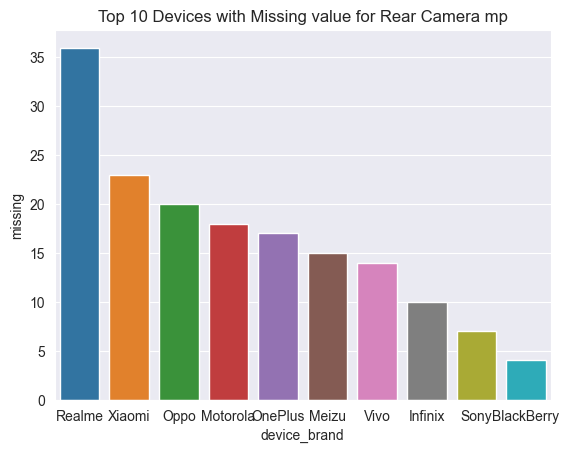

In [17]:
# Top 10 Devices with missing value for rear camera mp
sns.barplot(x=frame['missing'].index[0:10], y=frame['missing'][0:10]).set(
    title='Top 10 Devices with Missing value for Rear Camera mp')

In [18]:
# Correlation of rear camera mp to the target nomalized used price
corr_df = df[df['rear_camera_mp'].isna() == False]
corr_df['rear_camera_mp'].corr(corr_df['normalized_used_price'])

0.5873019744600579

despite the fact that most values are missing for Realme on this field, correlation between rear_camera_mp and the target variable 'normalized_used_price' is quite high at 0.59. It is important that it is handled carefully. The decision will be made further along in the project.

<h5>2.3.3 Missing Values - front_camera_mp</h5>

In [19]:
#showing devices with null for 'front_camera_mp'
#df[df['front_camera_mp'].isna()]

duckdb.sql('Select device_brand, os, release_year, rear_camera_mp, front_camera_mp FROM df WHERE "front_camera_mp" IS NULL')

┌──────────────┬─────────┬──────────────┬────────────────┬─────────────────┐
│ device_brand │   os    │ release_year │ rear_camera_mp │ front_camera_mp │
│   varchar    │ varchar │    int64     │     double     │     double      │
├──────────────┼─────────┼──────────────┼────────────────┼─────────────────┤
│ Google       │ Android │         2018 │           12.2 │            NULL │
│ Google       │ Android │         2018 │           12.2 │            NULL │
└──────────────┴─────────┴──────────────┴────────────────┴─────────────────┘

<AxesSubplot:>

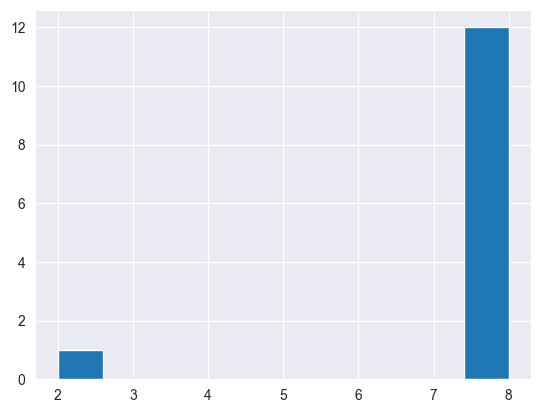

In [20]:
# histogram of google devices' front_camera_mp
df[df['device_brand'] == 'Google']['front_camera_mp'].hist()

Only 2 devices have missing front_camera_mp data. They are both Google devices. In addition, 12 out of 13 google devices with front_camera_mp data have the value 8. Based on this, we shall fill the missing 2 values with 8 as well.

In [21]:
# Filling missing 'front_camera_mp' with value 8.0 (the mode)
df['front_camera_mp'].fillna(8.0, inplace=True)

<h5>2.3.4 Missing Values - internal_memory</h5>

In [22]:
# Showing devices where 'internal_memory' is missing
#df[df['internal_memory'].isna()]
duckdb.sql('Select device_brand, os, release_year, internal_memory FROM df WHERE "internal_memory" IS NULL')

┌──────────────┬─────────┬──────────────┬─────────────────┐
│ device_brand │   os    │ release_year │ internal_memory │
│   varchar    │ varchar │    int64     │     double      │
├──────────────┼─────────┼──────────────┼─────────────────┤
│ Nokia        │ Others  │         2019 │            NULL │
│ Nokia        │ Others  │         2019 │            NULL │
│ Nokia        │ Others  │         2015 │            NULL │
│ Nokia        │ Others  │         2013 │            NULL │
└──────────────┴─────────┴──────────────┴─────────────────┘

In [23]:
# Showing all Nokia Devices
df[df['device_brand']=='Nokia']
#duckdb.sql('Select device_brand, os, release_year, internal_memory FROM df WHERE device_brand = Nokia')

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
110,Nokia,Android,16.56,yes,no,0.3,8.0,64.00,3.00,4000.0,200.0,2020,310,4.186012,5.004885
111,Nokia,Android,13.84,yes,no,0.3,5.0,16.00,2.00,3000.0,180.0,2020,193,3.616309,4.100161
112,Nokia,Android,13.84,yes,no,0.3,5.0,16.00,2.00,3000.0,180.0,2020,356,4.055430,4.591984
113,Nokia,Others,5.18,no,no,0.3,0.0,0.10,0.03,1020.0,90.5,2020,272,2.910174,3.399863
114,Nokia,Others,5.18,no,no,0.3,0.0,0.06,NaN,1020.0,91.3,2020,288,2.729159,2.911263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3384,Nokia,Android,15.29,yes,no,13.0,5.0,32.00,2.00,4000.0,183.0,2019,520,4.145671,4.438289
3385,Nokia,Android,15.32,yes,no,5.0,20.0,64.00,4.00,3500.0,180.0,2019,459,4.789407,5.127292
3386,Nokia,Android,15.32,yes,no,5.0,8.0,32.00,3.00,3500.0,180.0,2019,417,4.145354,4.950107
3387,Nokia,Others,5.28,yes,no,2.0,0.0,0.10,0.03,1500.0,118.0,2019,295,3.444576,4.085304


There are 106 Nokia devices. Only 4 have missing internal memory data. Every device is expected to have internal memory, so this is clearly erroneous. These records shall be deleted.

In [24]:
# Removing records where internal memory data is missing
df=df[df['internal_memory'].isna()==False]

<h5>2.3.5 Missing Values - ram</h5>

In [25]:
# Showing records with missing RAM
#df[df['ram'].isna()]
duckdb.sql('Select device_brand, os, release_year, ram FROM df WHERE "ram" IS NULL')

┌──────────────┬─────────┬──────────────┬────────┐
│ device_brand │   os    │ release_year │  ram   │
│   varchar    │ varchar │    int64     │ double │
├──────────────┼─────────┼──────────────┼────────┤
│ Nokia        │ Others  │         2020 │   NULL │
│ Nokia        │ Others  │         2020 │   NULL │
│ Nokia        │ Others  │         2016 │   NULL │
│ Nokia        │ Others  │         2013 │   NULL │
└──────────────┴─────────┴──────────────┴────────┘

In [26]:
#Total number of Nokia devices
#duckdb.sql('Select COUNT(device_brand) FROM df WHERE device_brand LIKE Nokia')
df[df['device_brand']=='Nokia'].size

1530

Again, only 4 Nokia devices do not have ram values. Every device is expected to have ram. Based on this, the 4 records with no ram values will be deleted.

In [27]:
# Removing records where RAM is missing (which are the Nokia devices) its 4 devices out of 1530.
df = df[df['ram'].isna()==False]

<h5>2.3.6 Missing Values - Battery</h5>

In [28]:
# Showing records where battery data is missing
#df[df['battery'].isna()]

duckdb.sql('Select device_brand, os, release_year, battery FROM df WHERE "battery" IS NULL')

┌──────────────┬─────────┬──────────────┬─────────┐
│ device_brand │   os    │ release_year │ battery │
│   varchar    │ varchar │    int64     │ double  │
├──────────────┼─────────┼──────────────┼─────────┤
│ Meizu        │ Android │         2014 │    NULL │
│ Meizu        │ Android │         2014 │    NULL │
│ Meizu        │ Android │         2014 │    NULL │
│ Microsoft    │ Windows │         2013 │    NULL │
│ Nokia        │ Others  │         2016 │    NULL │
└──────────────┴─────────┴──────────────┴─────────┘

In [29]:
# Number of records for Meizu devices
df[df['device_brand']=='Meizu'].size

930

In [30]:
# Number of records for Microsoft devices
df[df['device_brand']=='Microsoft'].size

330

Very few records have missing battery data. And every device is expected to have battery. So deletion is the solution.

In [31]:
# Deleting records where battery data is missing
df = df[df['battery'].isna()==False]

<h5>2.3.7 Missing Values - weight</h5>

In [32]:
# showing records where weight data is missing
#df[df['weight'].isna()]

duckdb.sql('Select device_brand, os, release_year, weight FROM df WHERE "weight" IS NULL')

┌──────────────┬─────────┬──────────────┬────────┐
│ device_brand │   os    │ release_year │ weight │
│   varchar    │ varchar │    int64     │ double │
├──────────────┼─────────┼──────────────┼────────┤
│ XOLO         │ Android │         2015 │   NULL │
│ XOLO         │ Android │         2015 │   NULL │
│ XOLO         │ Android │         2015 │   NULL │
│ XOLO         │ Android │         2015 │   NULL │
│ XOLO         │ Android │         2015 │   NULL │
│ XOLO         │ Windows │         2015 │   NULL │
│ XOLO         │ Android │         2015 │   NULL │
└──────────────┴─────────┴──────────────┴────────┘

In [33]:
df[df['device_brand']=='XOLO'].size

735

Deleting the very few records with missing weight Data.

In [34]:
# Deleting recrods where weight data is missing
df = df[df['weight'].isna()==False]

<h5>2.3.8 Solution for Missing rear_camera_mp values</h5>

In [35]:
#Number of missing records for 'rear_camera_mp' out of total devices
179/3434

0.052125800815375656

At this point, only rear_camera_mp has missing records. There are about 179 records with missing values for this field out of 3434. This is about 5% of the records. Earlier, it was established that 34 brands of devices have missing rear_camera_mp data. There was no pattern that could be found for this missing values. A decision shall be taken to delete these 179 records for now, but it may be revised at a later stage.

In [36]:
# Deleting recrods where rear_camera_mp data is missing
df = df[df['rear_camera_mp'].isna()==False]

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3255 entries, 0 to 3453
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   device_brand           3255 non-null   object 
 1   os                     3255 non-null   object 
 2   screen_size            3255 non-null   float64
 3   4g                     3255 non-null   object 
 4   5g                     3255 non-null   object 
 5   rear_camera_mp         3255 non-null   float64
 6   front_camera_mp        3255 non-null   float64
 7   internal_memory        3255 non-null   float64
 8   ram                    3255 non-null   float64
 9   battery                3255 non-null   float64
 10  weight                 3255 non-null   float64
 11  release_year           3255 non-null   int64  
 12  days_used              3255 non-null   int64  
 13  normalized_used_price  3255 non-null   float64
 14  normalized_new_price   3255 non-null   float64
dtypes: f

There are no more missing values from the dataset. The fields 'device_brand' and 'os' are still of object data type. This will be corrected as we approach the modelling stage.

<h2>3. Exploratory Data Analysis</h2>

In [38]:
# A look at some basic summary statistics
df.describe()

,screen_size,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
count,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000
mean,13.617757,9.478028,6.094962,52.105945,3.962983,3074.986943,182.483502,2015.767742,695.544086,4.342802,5.218530
std,3.850476,4.801198,6.597721,85.416490,1.225518,1296.576955,90.334064,2.187747,235.461637,0.579642,0.672706
min,5.080000,0.080000,0.000000,0.010000,0.020000,500.000000,69.000000,2013.000000,91.000000,1.536867,2.901422
25%,12.700000,5.000000,2.000000,16.000000,4.000000,2100.000000,140.475000,2014.000000,564.000000,4.019621,4.789157
50%,12.830000,8.000000,5.000000,32.000000,4.000000,3000.000000,158.000000,2015.000000,705.000000,4.377893,5.242329
75%,15.320000,13.000000,8.000000,64.000000,4.000000,3950.000000,182.000000,2018.000000,879.000000,4.726104,5.638123
max,30.710000,48.000000,32.000000,1024.000000,12.000000,9720.000000,855.000000,2020.000000,1094.000000,6.619433,7.847841


<h4>Which Brand and OS have higher Resale Value?</h4>

<h5>An initial look at the average resale value for brands and os</h5>

In [39]:
# Average resale value for each brand
df.groupby('device_brand').mean('normalized_used_price')['normalized_used_price'].sort_values(ascending=False)

device_brand
Apple         5.004553
Google        4.885651
Vivo          4.740658
OnePlus       4.700855
Realme        4.690620
Xiaomi        4.679006
Oppo          4.671122
Honor         4.665257
Huawei        4.654566
Meizu         4.539937
Asus          4.499233
Sony          4.496643
Samsung       4.466590
HTC           4.414975
Lenovo        4.379596
Motorola      4.376905
ZTE           4.345701
Coolpad       4.336698
Gionee        4.330395
LG            4.296958
BlackBerry    4.283445
Acer          4.217408
Panasonic     4.203015
Others        4.173466
Microsoft     4.156874
Nokia         4.003708
Alcatel       3.970264
XOLO          3.922928
Lava          3.848674
Karbonn       3.774956
Micromax      3.761856
Spice         3.694512
Celkon        3.230888
Name: normalized_used_price, dtype: float64

In [40]:
# Average resale value for each os
osframe = df.groupby('os').mean('normalized_used_price')['normalized_used_price'].sort_values(ascending=False)

osframe

os
iOS        4.956514
Android    4.382440
Windows    4.144844
Others     3.333646
Name: normalized_used_price, dtype: float64

[Text(0.5, 1.0, 'Average Prices for each OS')]

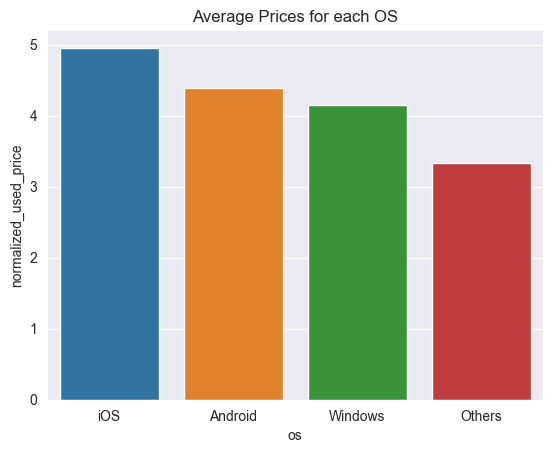

In [41]:
# Barplot with average prices for each OS
sns.barplot(y=osframe, x=osframe.index).set(title='Average Prices for each OS')

Initial check suggests that iOS has the highest average resale value

In [42]:
# Devices associated with the highest used price
frame = df.groupby('device_brand').mean('normalized_used_price')['normalized_used_price'].sort_values(ascending=False)
frame

device_brand
Apple         5.004553
Google        4.885651
Vivo          4.740658
OnePlus       4.700855
Realme        4.690620
Xiaomi        4.679006
Oppo          4.671122
Honor         4.665257
Huawei        4.654566
Meizu         4.539937
Asus          4.499233
Sony          4.496643
Samsung       4.466590
HTC           4.414975
Lenovo        4.379596
Motorola      4.376905
ZTE           4.345701
Coolpad       4.336698
Gionee        4.330395
LG            4.296958
BlackBerry    4.283445
Acer          4.217408
Panasonic     4.203015
Others        4.173466
Microsoft     4.156874
Nokia         4.003708
Alcatel       3.970264
XOLO          3.922928
Lava          3.848674
Karbonn       3.774956
Micromax      3.761856
Spice         3.694512
Celkon        3.230888
Name: normalized_used_price, dtype: float64

[Text(0.5, 1.0, 'Top 10 Average Prices for each Device')]

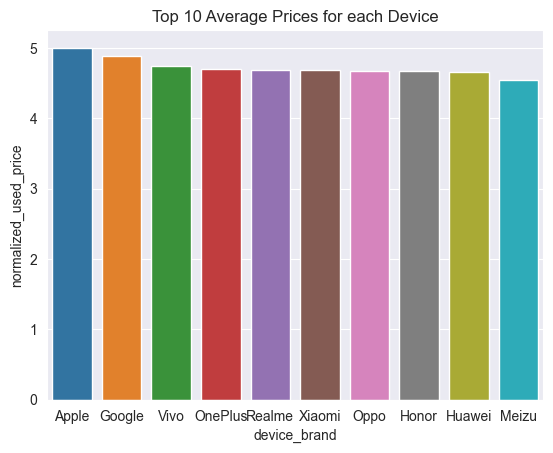

In [43]:
# Barplot showing top 10 devices associated with the highest used price
sns.barplot(y=frame[0:10], x=frame[0:10].index).set(title='Top 10 Average Prices for each Device')

<h5>Statistical Analysis - Average Resale Price</h5>

<h6>Getting a count of each device brand in the dataset</h6>

<AxesSubplot:xlabel='count', ylabel='device_brand'>

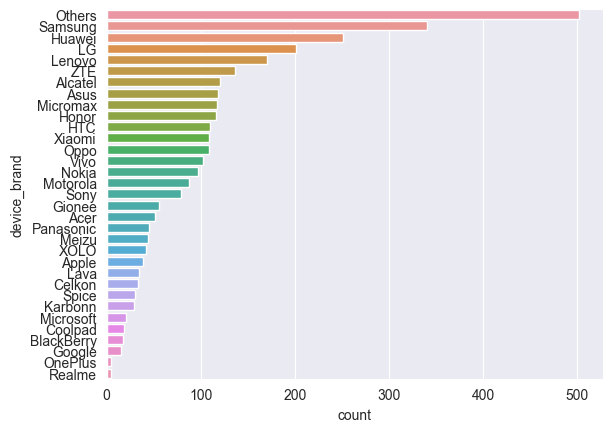

In [44]:
# A count of each device brand
sns.countplot(y=df['device_brand'], order=df['device_brand'].value_counts().index)

<h6>Testing for Normal Distribution - Normalized Used Price</h6>

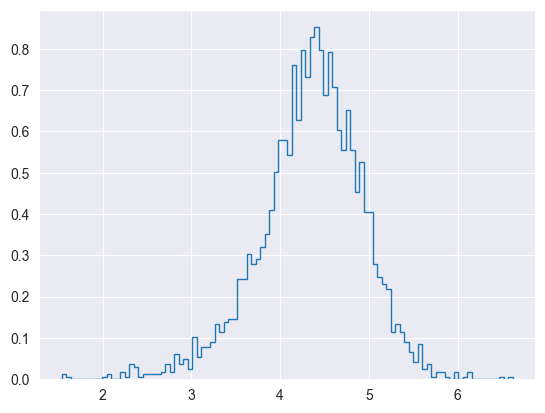

In [45]:
# Probability Density Function of the normalised used price
plt.hist(df['normalized_used_price'], bins=100, density=True, histtype='step')
plt.show()

The probability distribution function of the data seems to suggest a normal distribution function.

In [46]:
# Calculating empirical mean and empirical standard deviation
mean = df['normalized_used_price'].mean()
std = df['normalized_used_price'].std()

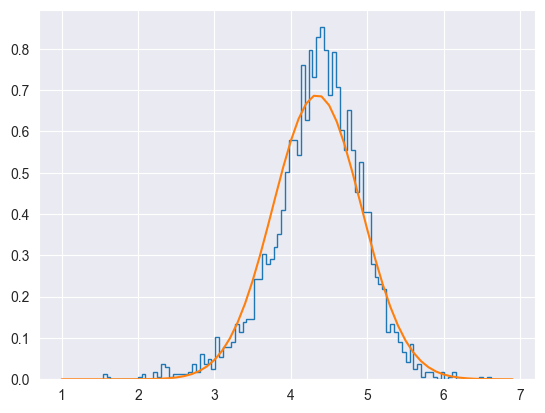

In [47]:
#A plot of the empirical pdf and a theoretical pdf based on parameters mean and std for comparison
x_axis = np.arange(1,7, 0.1)
y_axis = norm.pdf(x_axis, mean, std)
plt.hist(df['normalized_used_price'], bins=100, density=True, histtype='step')
plt.plot(x_axis, y_axis)
plt.show()

The normal theoretical pdf fits the data quite well. Lets take a look at the empirical cumulative distribution function (ecdf)

Below is an empirical cumulative distribution function of the data and the plot will also include random variables from a gaussian distribution with the parameters of mean and standard deviation sourced from the empirical dataset.

In [48]:
# A function for calculating the empirical cumulative distribution function
def ecdf(input):
    n = len(input)
    x=np.sort(input)
    y=np.arange(1,n+1)/n
    return x,y

In [49]:
# Generating random variables from normal distribution with empircal mean and standard deviation as parameters
rng = np.random.default_rng()
samples = rng.normal(mean, std, size=10000)

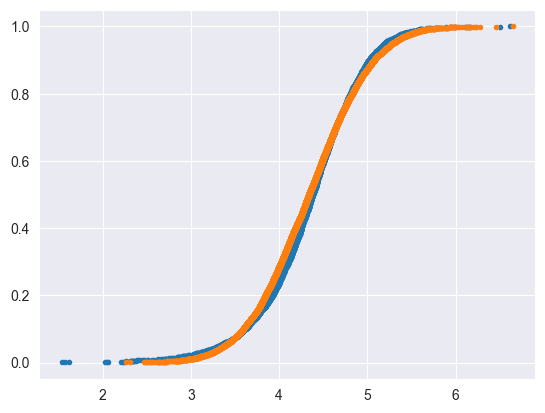

In [50]:
# Plotting the ecdf along with the cdf for the samples drawn from a normal distribution
emp_x,emp_y=ecdf(df['normalized_used_price'])
sample_x,sample_y=ecdf(samples)
plt.plot(emp_x,emp_y, marker='.', linestyle='none')
plt.plot(sample_x,sample_y, marker='.', linestyle='none')
plt.show()

Again, the theoretical cdf fits the empirical cdf very well. It is quite likely that the normalised_used_price has a normal distribution.

<h6>Statistical Test - Do Apple devices have a significantly different used price probability distribution from google devices?</h6>

If it were true that the price probability distribution was the same for Apple and Google devices, we would expect the difference in mean used price for Apple and Google devices to be statistically insignificant (due to random chance). An experiment shall be designed based on this. The null hypothesis is that the distribution of mean used price for Apple and Google devices is the same. The alternative hypothesis is that the distribution of mean used price for Apple and Google devices is different. See below:

<span style="color:green">H0: The mean used price probability distribution for Apple and Google devices is the same</span>
<span style="color:red">H1: The mean used price probability distribution for Apple and Google devices is significantly different</span>

We can say the test statistic for this experiment is the difference in mean used price and the null hypothesis expects it to be around zero. Below are the observations for the mean used price for apple and google

In [51]:
# Getting the mean prices for Apple and Google
apple_prices = df[df['device_brand']=='Apple']['normalized_used_price']
google_prices = df[df['device_brand']=='Google']['normalized_used_price']
apple_mean=apple_prices.mean()
google_mean=google_prices.mean()
print('Apple devices mean price is %s.\nGoogle devices mean price is %s.' % (apple_mean, google_mean))

Apple devices mean price is 5.004552904564102.
Google devices mean price is 4.885650815866667.


In [52]:
# Calculating the chosen statistic (difference of means)
statistic=apple_mean-google_mean
statistic

0.11890208869743546

Is this difference significant? To find out, we permutate the samples and calculate the test statistic for the permuted samples. The idea is that if apple and google mean prices come from the same distribution, then permutation of the sample will not cause a difference in the chosen statistic (difference in mean prices). We permutate the sample 50000 times. Based on the central limit theorem, we should be able to see a normal distribution of the statistic over the repetitions. Furthermore, the distribution should have a mean of about 0.

In [53]:
# Combining the two samples in preparation for permutation
data = pd.concat([apple_prices,google_prices])

In [54]:
# A function that permutates the input data and splits it into 2 equally sized samples. It then calculate the difference in mean from the samples and stores in a list. It does this 50000 times and returns the list.
def calcStatistics(data):
    statistics=[]

    for i in range(0,50000):
        type(int(len(data)/2))
        permuted = np.random.permutation(data)
        sample1 = permuted[0:(int(len(data)/2))]
        sample2 = permuted[int(len(data)/2):]
        statistics.append(sample1.mean() - sample2.mean())
    return statistics

In [55]:
# running the calcStatistics function to get the 50000 results from the permutations.
statistics = calcStatistics(data)
statistics

[0.006177559481481687,
 -0.040383499777777665,
 0.11040121496296162,
 0.0043606739259276495,
 -0.04474191333333266,
 0.07978251622222299,
 -0.06744773585185193,
 -0.28105564111111114,
 0.15723286385185098,
 0.03174349496296269,
 -0.029636387999999236,
 -0.012723162814814337,
 -0.007322233037038828,
 0.0930932147407404,
 -0.038913357851852126,
 0.10814944740740717,
 0.09737107325926075,
 0.1804602339999999,
 -0.15858646555555556,
 0.07722503748148046,
 -0.11134305503703601,
 -0.14897607044444428,
 0.1795953057037032,
 -0.1265005934074086,
 0.047673251777777814,
 -0.04892427592592519,
 0.07038567177777733,
 -0.18996621081481457,
 0.1442841722962953,
 0.0010219597777778588,
 -0.10205849577777926,
 -0.05822478881481352,
 0.10912263962963031,
 -0.15283781133333463,
 0.08347499688889037,
 0.10258345629629506,
 -0.2175110203703703,
 0.01953407214814895,
 -0.0858406528148139,
 -0.23409677074073976,
 0.01066798311111139,
 -0.17279877281481593,
 -0.039961667777777876,
 0.09894582748148117,
 0.09

(array([1.33626683e-02, 5.72685785e-03, 9.54476309e-03, 1.52716209e-02,
        1.14537157e-02, 1.14537157e-02, 2.29074314e-02, 4.00880050e-02,
        4.58148628e-02, 5.34506733e-02, 9.16297257e-02, 9.73565835e-02,
        9.54476309e-02, 1.10719252e-01, 1.62260973e-01, 2.15711646e-01,
        2.29074314e-01, 3.07341371e-01, 3.26430898e-01, 4.23787481e-01,
        4.40968055e-01, 4.96327681e-01, 6.54770748e-01, 7.46400474e-01,
        8.43757057e-01, 9.85019551e-01, 1.04992394e+00, 1.11291938e+00,
        1.26372663e+00, 1.36108322e+00, 1.61115601e+00, 1.71996631e+00,
        1.97003910e+00, 1.95285853e+00, 2.10748369e+00, 2.17620598e+00,
        2.31174162e+00, 2.55036070e+00, 2.52363536e+00, 2.67444262e+00,
        2.86533788e+00, 2.85006626e+00, 2.87488264e+00, 2.91687960e+00,
        2.92833332e+00, 2.93978703e+00, 3.04287047e+00, 2.93215122e+00,
        2.76607234e+00, 2.76798130e+00, 2.76034549e+00, 2.51027269e+00,
        2.44155040e+00, 2.41864297e+00, 2.31746848e+00, 2.160934

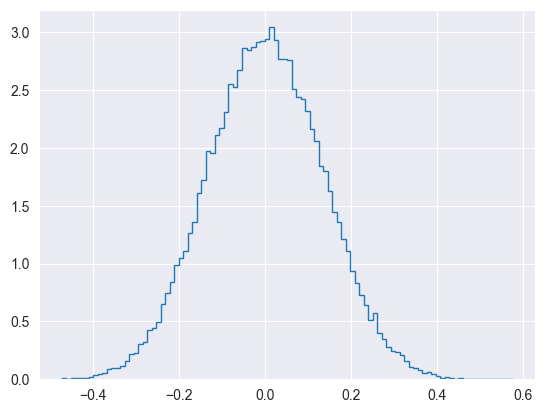

In [56]:
# Plotting the results in a histogram (Percentage Distribution Function Plot)
plt.hist(statistics, bins=100, density=True, histtype='step')

The plot above suggests that the null hypothesis holds true. The mean of the distribution is about zero.

It is pretty clear that the average price difference is about zero and that the statistics, which is our observation and has a mean difference of 0.12 is surely statistically significant. Below is the p-value for the experiment:

In [57]:
pvalue = sum(statistics>=statistic)/len(statistics)
pvalue

0.1892

The probability of getting a difference of mean of 0.12 between apple prices and google prices is 18.9% assuming the distributions of each are the same. This is significant, meaning that there isn't any significant difference between the mean values of apple prices and google prices. In other words, apple devices and google devices are more or less similarly priced

What if we compare between apple, the most expensive device on average and Nokia, one with a much lower average price? Let's see below:

In [58]:
Nokia_prices = df[df['device_brand']=='Nokia']['normalized_used_price']
stat = apple_prices.mean() - Nokia_prices.mean()
stat

1.000844748038329

In [59]:
data2 = pd.concat([apple_prices,Nokia_prices])
stats = calcStatistics(data2)

In [60]:
pvalue2 = sum(stats>=stat)/len(stats)
pvalue2

0.0

In the case of Apple and Nokia, the pvalue is 0 meaning the difference is very significant. Apple and Nokia have a significant difference in prices.

Next we will compare apple devices to all other devices and see if there is any significant difference.

In [61]:
# A function that calculates p values given groups of devices along with their normalised used price.
def getPValues(devices, apple):
    statistics = {}
    pvalues = {}
    for i in devices:
        statistic = apple.mean() - i[1]['normalized_used_price'].mean()
        data = pd.concat([apple, i[1]['normalized_used_price']])
        statistics[i[0]] = calcStatistics(data)
        pvalues[i[0]] = sum(statistics[i[0]]>=statistic)/len(statistics[i[0]])
    return pvalues

In [62]:
devices=df.groupby('device_brand')

In [63]:
pvals = getPValues(devices, apple_prices)
pvals

{'Acer': 0.0,
 'Alcatel': 0.0,
 'Apple': 0.5033,
 'Asus': 0.0,
 'BlackBerry': 0.0,
 'Celkon': 0.0,
 'Coolpad': 0.0,
 'Gionee': 0.0,
 'Google': 0.18946,
 'HTC': 0.0,
 'Honor': 0.0,
 'Huawei': 0.0,
 'Karbonn': 0.0,
 'LG': 0.0,
 'Lava': 0.0,
 'Lenovo': 0.0,
 'Meizu': 0.0,
 'Micromax': 0.0,
 'Microsoft': 0.0,
 'Motorola': 0.0,
 'Nokia': 0.0,
 'OnePlus': 0.02768,
 'Oppo': 0.0,
 'Others': 0.0,
 'Panasonic': 0.0,
 'Realme': 0.02494,
 'Samsung': 0.0,
 'Sony': 0.0,
 'Spice': 0.0,
 'Vivo': 0.0001,
 'XOLO': 0.0,
 'Xiaomi': 2e-05,
 'ZTE': 0.0}

[Text(0.5, 1.0, 'P Values for each device')]

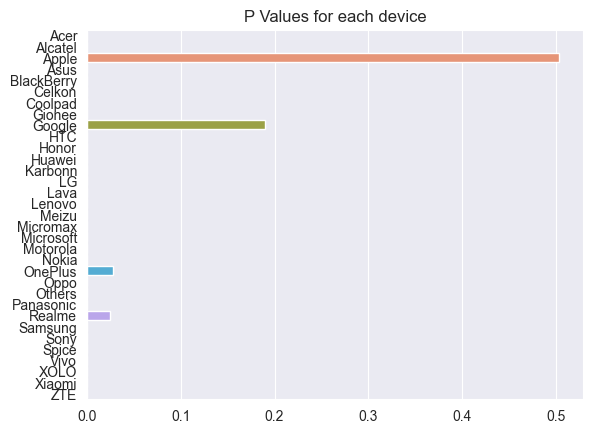

In [64]:
sns.barplot(y=list(pvals.keys()), x=list(pvals.values())).set(title='P Values for each device')

Only google has a pvalue above 0.05. For the rest, the difference in mean price is very significant. Based on this, Apple and Google are the devices with the highest normalized used price.

In [65]:
differences = (devices.mean('normalized_used_price')['normalized_used_price'] - apple_mean).sort_values()

In [66]:
differences

device_brand
Celkon       -1.773665e+00
Spice        -1.310041e+00
Micromax     -1.242697e+00
Karbonn      -1.229597e+00
Lava         -1.155879e+00
XOLO         -1.081625e+00
Alcatel      -1.034289e+00
Nokia        -1.000845e+00
Microsoft    -8.476787e-01
Others       -8.310868e-01
Panasonic    -8.015383e-01
Acer         -7.871448e-01
BlackBerry   -7.211082e-01
LG           -7.075950e-01
Gionee       -6.741578e-01
Coolpad      -6.678547e-01
ZTE          -6.588521e-01
Motorola     -6.276483e-01
Lenovo       -6.249574e-01
HTC          -5.895784e-01
Samsung      -5.379633e-01
Sony         -5.079098e-01
Asus         -5.053199e-01
Meizu        -4.646157e-01
Huawei       -3.499871e-01
Honor        -3.392957e-01
Oppo         -3.334310e-01
Xiaomi       -3.255466e-01
Realme       -3.139329e-01
OnePlus      -3.036982e-01
Vivo         -2.638950e-01
Google       -1.189021e-01
Apple         8.881784e-16
Name: normalized_used_price, dtype: float64

[Text(0.5, 1.0, 'Differences in mean price from the mean price of Apple Devices')]

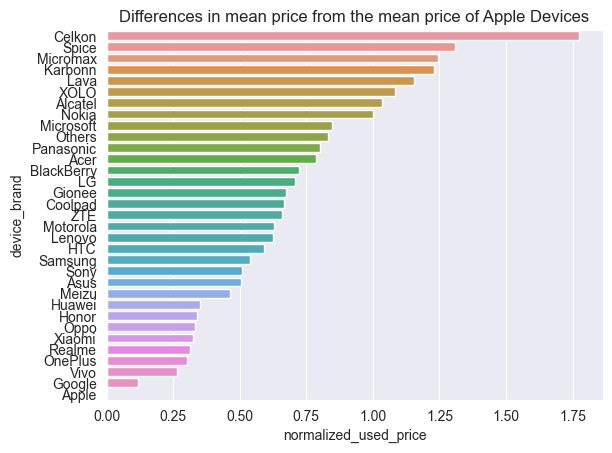

In [67]:
sns.barplot(x=abs(differences), y=differences.index).set(title='Differences in mean price from the mean price of Apple Devices')

A similar experiment could be conducted based on operating system instead of device name:

In [68]:
ios_prices = df[df['os']=='iOS']['normalized_used_price']
ios_mean = ios_prices.mean()

In [69]:
ios_prices

391     5.359836
392     4.562680
642     4.937061
643     4.794633
644     5.808022
645     6.158969
646     5.570594
647     5.583459
648     5.492650
649     4.923478
650     4.522115
651     5.175415
652     5.120685
653     5.759186
654     5.290789
655     4.669459
656     4.750568
657     4.681112
658     5.373471
659     4.437461
660     4.633077
661     5.170370
662     5.558872
663     4.463146
664     4.591984
665     4.372986
666     4.251776
667     3.930648
668     4.628398
669     4.422088
670     3.879706
671     4.666359
3444    5.011901
3445    5.340466
3446    5.440164
3447    5.100902
Name: normalized_used_price, dtype: float64

In [70]:
operating_systems=df.groupby('os')

In [71]:
os_differences = (operating_systems.mean('normalized_used_price')['normalized_used_price'] - ios_mean).sort_values()

In [72]:
os_differences

os
Others    -1.622867
Windows   -0.811669
Android   -0.574074
iOS        0.000000
Name: normalized_used_price, dtype: float64

In [73]:
pvalsos = getPValues(operating_systems, ios_prices)
pvalsos

{'Android': 0.0, 'Others': 0.0, 'Windows': 0.0, 'iOS': 0.4987}

It is pretty clear that iOS has the highest used price on average.

<H5>Does Average Resale Price in Recent Years</h5>

<AxesSubplot:xlabel='release_year', ylabel='normalized_used_price'>

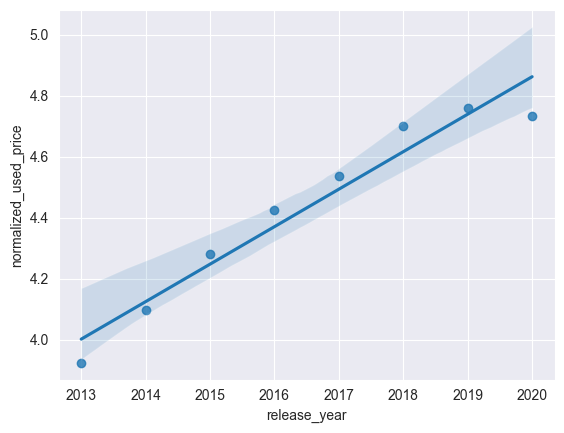

In [74]:
# Plot of average resale price for each year
frame = df.groupby('release_year').mean('normalized_used_price')['normalized_used_price']
#frame
sns.regplot(y=frame, x=frame.index)

Its easy to see that the normalized used price increases as the release year increases. So the average phone resale value does not decrease in recent years, it actually increases. Possibly because phones are improving at a quick rate and so is the cost of making them.

<h5>Heatmap to Understand Correlation of Different Features with Target</h5>

In [75]:
sns.heatmap(df.corr(numeric_only=True), cmap="YlGnBu", annot=True)

TypeError: corr() got an unexpected keyword argument 'numeric_only'

According the heatmap above, normalized used price is most correlated with screen size and battery. In both cases, the correlation is positive at 0.61 Pearson Correlation Coefficient.

In [76]:
# Showing correlation coefficient for each of the variables with the target 'normalized_used_price'
corr_matrix = df.corr(numeric_only=True)
print(corr_matrix['normalized_used_price'])

TypeError: corr() got an unexpected keyword argument 'numeric_only'

Quite a number of variables here have a pretty high correlation with the target variable normalized used price.

<h5>Analysis of Categorical Variables using Chi-Squared, Cramer's V, and ANOVA</h5>

<h6>Analysis - CHI 2 TEST & Cramers V</h6>

In [77]:
df.columns

Index(['device_brand', 'os', 'screen_size', '4g', '5g', 'rear_camera_mp',
       'front_camera_mp', 'internal_memory', 'ram', 'battery', 'weight',
       'release_year', 'days_used', 'normalized_used_price',
       'normalized_new_price'],
      dtype='object')

<h7>Chi 2 - Device_brand and OS</h7>

With a chi 2 statistic of 4821.103 and a p-value of zero, there is a clear indication that the alternate hypothesis should be accepted. There is indeed a relationship between device brand and os. Let's see the cramer's v test:

<h3>Analysis - Cramer's V</h3>

In [78]:
table1=pd.crosstab(index=df['device_brand'],columns=df['4g'])
table1

4g,no,yes
device_brand,,
Acer,35,16
Alcatel,63,58
Apple,0,39
Asus,42,76
BlackBerry,2,16
Celkon,33,0
Coolpad,0,19
Gionee,26,30
Google,1,14


In [79]:
res = chi2_contingency(table1)
res

(883.2812121326904,
 5.921453757052821e-165,
 32,
 array([[ 17.31336406,  33.68663594],
        [ 41.07680492,  79.92319508],
        [ 13.23963134,  25.76036866],
        [ 40.05837174,  77.94162826],
        [  6.11059908,  11.88940092],
        [ 11.20276498,  21.79723502],
        [  6.4500768 ,  12.5499232 ],
        [ 19.01075269,  36.98924731],
        [  5.0921659 ,   9.9078341 ],
        [ 37.34254992,  72.65745008],
        [ 39.37941628,  76.62058372],
        [ 85.20890937, 165.79109063],
        [  9.84485407,  19.15514593],
        [ 68.23502304, 132.76497696],
        [ 11.5422427 ,  22.4577573 ],
        [ 58.05069124, 112.94930876],
        [ 14.93701997,  29.06298003],
        [ 39.71889401,  77.28110599],
        [  7.12903226,  13.87096774],
        [ 29.87403994,  58.12596006],
        [ 32.92933948,  64.07066052],
        [  1.69738863,   3.30261137],
        [ 37.0030722 ,  71.9969278 ],
        [170.41781874, 331.58218126],
        [ 15.2764977 ,  29.7235023 ],


In [80]:
res.statistic

AttributeError: 'tuple' object has no attribute 'statistic'

In [81]:
table1.shape

(33, 2)

In [82]:
np.sum(table1)

4g
no     1105
yes    2150
dtype: int64

In [83]:
minimum = min(table1.shape)
np.sqrt(res.statistic / ((minimum - 1) * 3255))

AttributeError: 'tuple' object has no attribute 'statistic'

With degrees of freedom of 1, a Cramer's V value of 0.52 indicates that there is a moderately strong association between device brand and whether it is 4g.

<h6>Statistical Analysis - ANOVA</h6>

In [84]:
df

,device_brand,os,screen_size,4g,5g,rear_camera_mp,front_camera_mp,internal_memory,ram,battery,weight,release_year,days_used,normalized_used_price,normalized_new_price
0,Honor,Android,14.50,yes,no,13.0,5.0,64.0,3.0,3020.0,146.0,2020,127,4.307572,4.715100
1,Honor,Android,17.30,yes,yes,13.0,16.0,128.0,8.0,4300.0,213.0,2020,325,5.162097,5.519018
2,Honor,Android,16.69,yes,yes,13.0,8.0,128.0,8.0,4200.0,213.0,2020,162,5.111084,5.884631
3,Honor,Android,25.50,yes,yes,13.0,8.0,64.0,6.0,7250.0,480.0,2020,345,5.135387,5.630961
4,Honor,Android,15.32,yes,no,13.0,8.0,64.0,3.0,5000.0,185.0,2020,293,4.389995,4.947837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3447,Apple,iOS,15.27,yes,no,8.0,7.0,64.0,4.0,3110.0,194.0,2019,208,5.100902,6.287933
3450,Asus,Android,15.24,yes,no,13.0,8.0,128.0,8.0,4000.0,200.0,2018,541,5.037732,6.251538
3451,Alcatel,Android,15.80,yes,no,13.0,5.0,32.0,3.0,4000.0,165.0,2020,201,4.357350,4.528829
3452,Alcatel,Android,15.80,yes,no,13.0,5.0,32.0,2.0,4000.0,160.0,2020,149,4.349762,4.624188


In [85]:
values=df.groupby('os')['normalized_used_price'].apply(list)

In [86]:
results = f_oneway(values[0], values[1], values[2], values[3])
results

F_onewayResult(statistic=173.94173679670322, pvalue=1.3841846738307663e-104)

In [87]:
values

os
Android    [4.307572449, 5.162096647, 5.111083765, 5.1353...
Others     [3.875566468, 2.910174385, 3.370738174, 3.7584...
Windows    [4.590969837, 3.755369195, 3.276389731, 3.8932...
iOS        [5.359835707, 4.562680134, 4.937060513, 4.7946...
Name: normalized_used_price, dtype: object

array([[<AxesSubplot:title={'center':'screen_size'}>,
        <AxesSubplot:title={'center':'rear_camera_mp'}>,
        <AxesSubplot:title={'center':'front_camera_mp'}>],
       [<AxesSubplot:title={'center':'internal_memory'}>,
        <AxesSubplot:title={'center':'ram'}>,
        <AxesSubplot:title={'center':'battery'}>],
       [<AxesSubplot:title={'center':'weight'}>,
        <AxesSubplot:title={'center':'release_year'}>,
        <AxesSubplot:title={'center':'days_used'}>],
       [<AxesSubplot:title={'center':'normalized_used_price'}>,
        <AxesSubplot:title={'center':'normalized_new_price'}>,
        <AxesSubplot:>]], dtype=object)

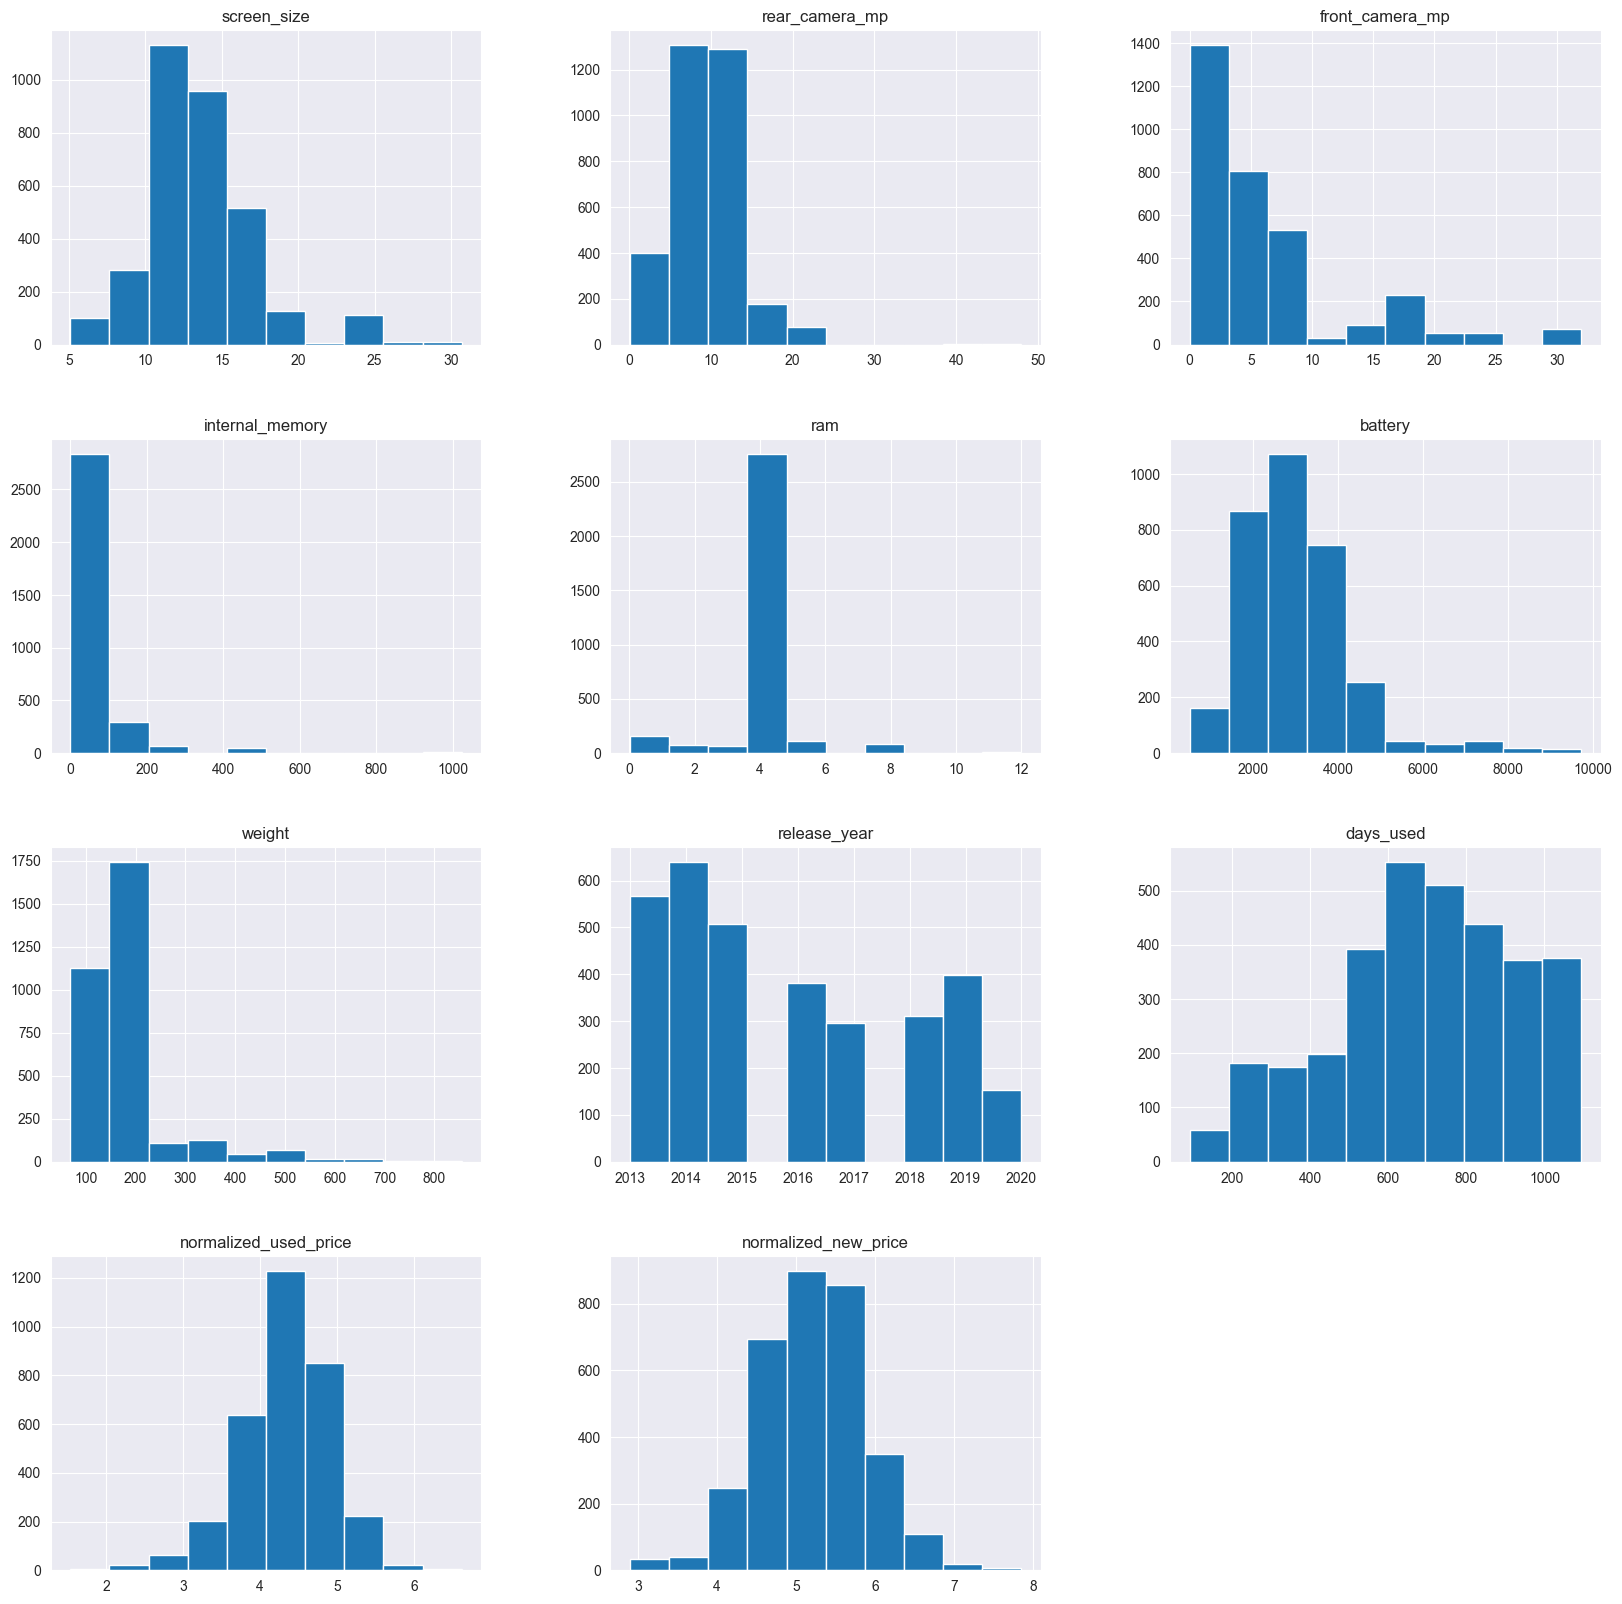

In [88]:
fields = df.columns
df.hist(figsize=(20,20))

Some of the fields look normally distributed while others don't. front_camera_mp, internal_memory, weight all seem like they could go closer to normal distribution through the use of log function. We could also explore what to do with release_year and days_used.

In [89]:
# A look at the unique values and counts for device_brand
duckdb.sql('select device_brand, COUNT(*) AS COUNTS FROM df GROUP BY device_brand ORDER BY COUNTS desc')

┌──────────────┬────────┐
│ device_brand │ COUNTS │
│   varchar    │ int64  │
├──────────────┼────────┤
│ Others       │    502 │
│ Samsung      │    341 │
│ Huawei       │    251 │
│ LG           │    201 │
│ Lenovo       │    171 │
│ ZTE          │    136 │
│ Alcatel      │    121 │
│ Asus         │    118 │
│ Micromax     │    117 │
│ Honor        │    116 │
│  ·           │      · │
│  ·           │      · │
│  ·           │      · │
│ Lava         │     34 │
│ Celkon       │     33 │
│ Spice        │     30 │
│ Karbonn      │     29 │
│ Microsoft    │     21 │
│ Coolpad      │     19 │
│ BlackBerry   │     18 │
│ Google       │     15 │
│ OnePlus      │      5 │
│ Realme       │      5 │
├──────────────┴────────┤
│  33 rows (20 shown)   │
└───────────────────────┘

There are 34 different device brands and the one with the lowest count is 10.

In [90]:
# A look at the unique values and counts for os
duckdb.sql('select os, COUNT(*) FROM df GROUP BY os ')

┌─────────┬──────────────┐
│   os    │ count_star() │
│ varchar │    int64     │
├─────────┼──────────────┤
│ Windows │           65 │
│ Others  │          128 │
│ Android │         3026 │
│ iOS     │           36 │
└─────────┴──────────────┘

In [91]:
# A look at the unique values and counts for 4g
duckdb.sql('select "4g", COUNT(*) FROM df GROUP BY "4g"')

┌─────────┬──────────────┐
│   4g    │ count_star() │
│ varchar │    int64     │
├─────────┼──────────────┤
│ yes     │         2150 │
│ no      │         1105 │
└─────────┴──────────────┘

In [92]:
#Replacing yes and no with 1 and 0 respectively
df['4g'].replace({'yes':1, 'no':0}, inplace=True)
df['4g']

0       1
1       1
2       1
3       1
4       1
       ..
3447    1
3450    1
3451    1
3452    1
3453    1
Name: 4g, Length: 3255, dtype: int64

In [93]:
# A look at the unique values and counts for 5g
duckdb.sql('select "5g", COUNT(*) FROM df GROUP BY "5g"')

┌─────────┬──────────────┐
│   5g    │ count_star() │
│ varchar │    int64     │
├─────────┼──────────────┤
│ yes     │           85 │
│ no      │         3170 │
└─────────┴──────────────┘

In [94]:
#Replacing yes and no with 1 and 0 respectively
df['5g'].replace({'yes':1, 'no':0}, inplace=True)
df['5g']

0       0
1       1
2       1
3       1
4       0
       ..
3447    0
3450    0
3451    0
3452    0
3453    0
Name: 5g, Length: 3255, dtype: int64

In [95]:
duckdb.sql('select "days_used", COUNT(*) FROM df GROUP BY "days_used"')

┌───────────┬──────────────┐
│ days_used │ count_star() │
│   int64   │    int64     │
├───────────┼──────────────┤
│       268 │            2 │
│       933 │            2 │
│        91 │            1 │
│       306 │            3 │
│       244 │            2 │
│       254 │            3 │
│        92 │            2 │
│       166 │            1 │
│      1016 │            6 │
│       680 │            5 │
│        ·  │            · │
│        ·  │            · │
│        ·  │            · │
│       446 │            2 │
│       203 │            2 │
│       281 │            1 │
│       151 │            1 │
│       292 │            1 │
│       113 │            1 │
│       265 │            1 │
│       197 │            1 │
│       176 │            2 │
│       315 │            1 │
├───────────┴──────────────┤
│   878 rows (20 shown)    │
└──────────────────────────┘

The average price is about 5.2 (normalized). A quick look at the distribution of the dataset:

<AxesSubplot:>

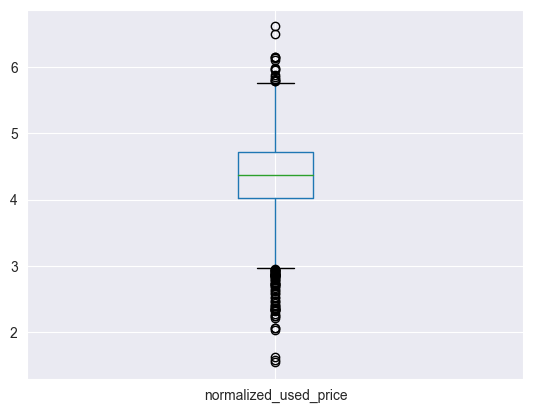

In [96]:
df[['normalized_used_price']].boxplot()

<AxesSubplot:>

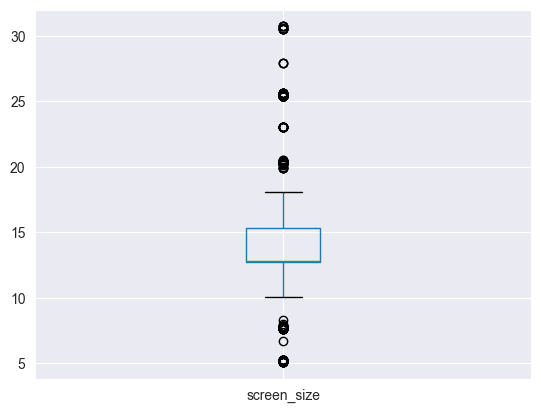

In [97]:
df[['screen_size']].boxplot()

<AxesSubplot:>

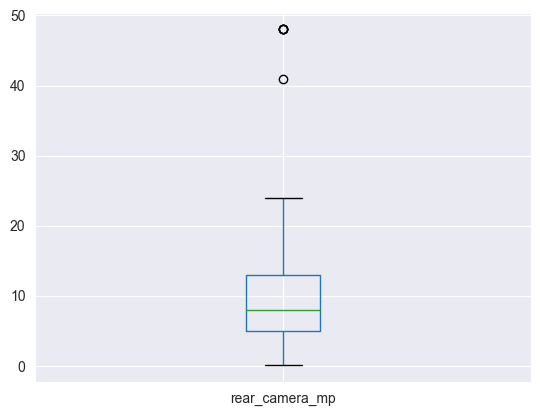

In [98]:
df[['rear_camera_mp']].boxplot()

<AxesSubplot:>

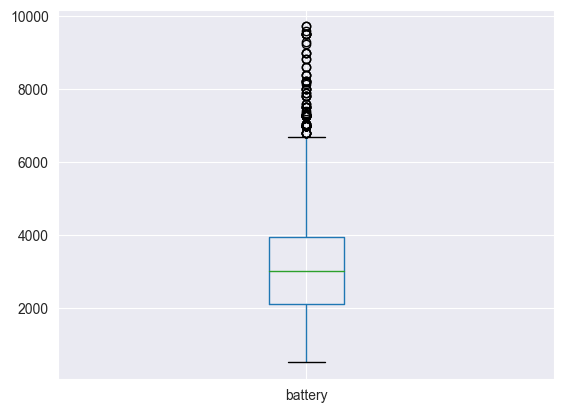

In [99]:
df[['battery']].boxplot()

<AxesSubplot:>

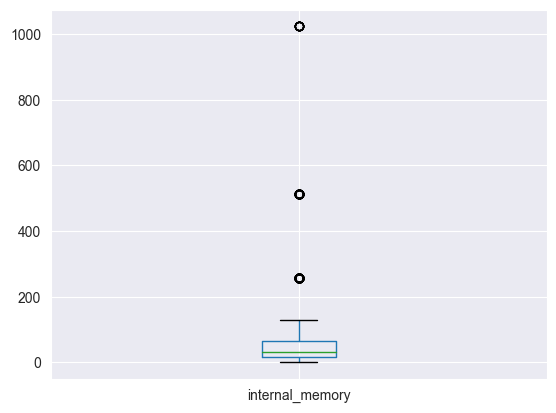

In [100]:
df[['internal_memory']].boxplot()

As can be seen in the box plots above, the fields with distribution closer to normal tend to have fewer outliers or less extreme outliers.

Since the target variable and used price are both already normalized, the distribution for both fields is already quite normal.

<AxesSubplot:xlabel='days_used', ylabel='normalized_used_price'>

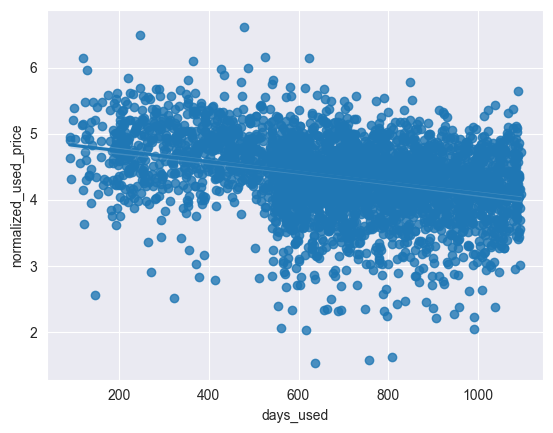

In [101]:
sns.regplot(x=df['days_used'], y=df['normalized_used_price'])

Normalized used price decreases as the days_used increases according to the regplot above

In [102]:
# Showing correlation between days_used and normalized_used_price
df['days_used'].corr(df['normalized_used_price'])

-0.3292945694942568

There are a lot of categorical variables in the dataset. We can perform some statistical tests in an attempt to see whether we can learn something from the data.

In [103]:
df.to_csv('../data/sales_clean.csv')